# Natural Language Processing: Pretraining

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
import dl2_torch as d2l
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch.nn.functional as F
from collections import Counter
import math
import random
import collections

d:\Anaconda3\envs\data_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Word Embedding (word2vec) [词嵌入](!https://d2l.ai/chapter_natural-language-processing-pretraining/word2vec.html#the-continuous-bag-of-words-cbow-model)  

- The word2vec 工具包含 skip-gram 和连续词袋模型。
- （Skip-Gram model）假设一个词可以用来生成文本序列中的其周围词；而连续词袋模型（Continuous Bag of Words）假设中心词是基于其周围上下文词生成的。
- 两种方法通过最大化似然函数来学习最优词嵌入表示

### 1. Skip-Gram 

周围词由中间词生成  $ P(\textrm{"the"},\textrm{"man"},\textrm{"his"},\textrm{"son"}\mid\textrm{"loves"}) = P(\textrm{"the"}\mid\textrm{"loves"})\cdot P(\textrm{"man"}\mid\textrm{"loves"})\cdot P(\textrm{"his"}\mid\textrm{"loves"})\cdot P(\textrm{"son"}\mid\textrm{"loves"}).$  

某个中心词生成周围词的概率  $$ P(w_o \mid w_c) = \frac{\exp(\mathbf{u}_o^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)}, $$  
整个句子的概率即 以每个词为中心生成周围词的概率的乘积  $ \prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t)}), $  
最小化对应的负对数似然函数，即完成训练过程。  $ - \sum_{t=1}^{T} \sum_{-m \leq j \leq m,\ j \neq 0} \textrm{log}\, P(w^{(t+j)} \mid w^{(t)}). $ 
  $$ \log P(w_o \mid w_c) =\mathbf{u}_o^\top \mathbf{v}_c - \log\left(\sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)\right). $$
  $$ \begin{split}\begin{aligned}\frac{\partial \textrm{log}\, P(w_o \mid w_c)}{\partial \mathbf{v}_c}&= \mathbf{u}_o - \frac{\sum_{j \in \mathcal{V}} \exp(\mathbf{u}_j^\top \mathbf{v}_c)\mathbf{u}_j}{\sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)}\\&= \mathbf{u}_o - \sum_{j \in \mathcal{V}} \left(\frac{\exp(\mathbf{u}_j^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)}\right) \mathbf{u}_j\\&= \mathbf{u}_o - \sum_{j \in \mathcal{V}} P(w_j \mid w_c) \mathbf{u}_j.\end{aligned}\end{split} $$

## 2.  Approximate Training [近似训练](!https://d2l.ai/chapter_natural-language-processing-pretraining/approx-training.html#hierarchical-softmax)

由于按照原始训练方式计算梯度，需要计算整个字典大小的梯度数量（即上式  $ \frac{\partial \textrm{log}\, P(w_o \mid w_c)}{\partial \mathbf{v}_c} $），因此考虑减少计算量的近似计算方法

- 负采样通过考虑涉及正例和负例的相互独立事件来构建损失函数。训练的计算成本与每一步的**噪声词**数量线性相关。  
- 层次 softmax 通过二叉树中从根节点到叶节点的路径构建损失函数。训练每一步的计算成本取决于字典大小的对数。  


### 负采样

负采样将窗口同时出现词 这个事件理解为 $ P(w^{(t+j)} \mid w^{(t)}) =P(D=1\mid w^{(t)}, w^{(t+j)})\prod_{k=1,\ w_k \sim P(w)}^K P(D=0\mid w^{(t)}, w_k). $  
即考虑中心词与词典中的所有其他词对， 出现在当前窗口中的，其概率为$ P(D=1\mid w^{(t)}, w^{(t+j)}) $, 剩余没有出现在当前窗口中的，其概率为 $ P(D=0\mid w^{(t)}, w_k) $, 整个概率表示当前出现的窗口词的概率  
实际操作的时候， 噪声词组采用采样K个的方式进行估计  

skip-gram 模型  
$$  \begin{split}\begin{aligned}
-\log P(w^{(t+j)} \mid w^{(t)})
=& -\log P(D=1\mid w^{(t)}, w^{(t+j)}) - \sum_{k=1,\ w_k \sim P(w)}^K \log P(D=0\mid w^{(t)}, w_k)\\
=&-  \log\, \sigma\left(\mathbf{u}_{i_{t+j}}^\top \mathbf{v}_{i_t}\right) - \sum_{k=1,\ w_k \sim P(w)}^K \log\left(1-\sigma\left(\mathbf{u}_{h_k}^\top \mathbf{v}_{i_t}\right)\right)\\
=&-  \log\, \sigma\left(\mathbf{u}_{i_{t+j}}^\top \mathbf{v}_{i_t}\right) - \sum_{k=1,\ w_k \sim P(w)}^K \log\sigma\left(-\mathbf{u}_{h_k}^\top \mathbf{v}_{i_t}\right).
\end{aligned}\end{split}  $$


CBOW 负采样最终损失公式  
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202410312043052.png " width='700px' >
</div>  

### 层次 softmax  
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202410312053511.png" width='700px' >
</div>  

某个中心词对应生成其他词的概率    $ P(w_o \mid w_c) = \prod_{j=1}^{L(w_o)-1} \sigma\left( [\![  n(w_o, j+1) = \textrm{leftChild}(n(w_o, j)) ]\!] \cdot \mathbf{u}_{n(w_o, j)}^\top \mathbf{v}_c\right), $  
公式中中心词 $ w_c $ 的向量由 $\mathbf{v}_c$ 编码， 生成词 $ w_o $ 由路径上的非叶子节点 $\mathbf{u}_{n(w_o, j)}$ 的向量编码， 且借由左右符号不同保证不会有相同概率的情况。  

由于 $ \sigma(x)+\sigma(-x) = 1 $  因此整个树的概率为 $ \sum_{w \in \mathcal{V}} P(w \mid w_c) = 1. $

## 3. Word2Vec 实现

### 3.1 数据集
 Penn Tree Bank (PTB)

In [3]:
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

#@save
def read_ptb():
    """Load the PTB dataset into a list of text lines."""
    data_dir = d2l.download_extract('ptb')
    # Read the training set
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()

构建了一个词汇表，其中任何出现次数少于 10 次的单词都被替换为 '<unk>' 标记

In [5]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

### 3.2 子采样 
减少高频词（例如 the， a 等）的频率，  
例如，考虑上下文窗口中的词“chip”：直观上，它与低频词“intel”的共现比与高频词“a”的共现更有助于训练。此外，使用大量（高频）词进行训练速度较慢。  
单词以 $ P(w_i) = \max\left(1 - \sqrt{\frac{t}{f(w_i)}}, 0\right), $ 的概率被丢弃，即以 $  \sqrt{\frac{t}{f(w_i)}} $ 的概率保留  
常数 t 是超参数，只有当相对频率 f(wi) （是单词 wi 数量与数据集中总单词数量的比率） >t 时，才能丢弃（高频）单词 wi

In [6]:
def subsample(sentences, vocab):
    """Subsample high-frequency words."""
    # Exclude unknown tokens ('<unk>')
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = Counter([
        token for line in sentences for token in line])
    num_tokens = sum(counter.values())

    # Return True if `token` is kept during subsampling
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))

    return ([[token for token in line if keep(token)] for line in sentences],
            counter)

subsampled, counter = subsample(sentences, vocab)

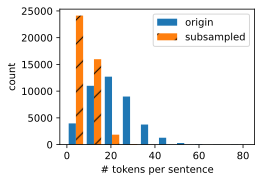

In [9]:
d2l.show_list_len_pair_hist(['origin', 'subsampled'], '# tokens per sentence',
                            'count', sentences, subsampled);

删除高频词显著缩短了句子, 且保留低频词的数目  
将子采样后数据映射为索引

In [9]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [6697, 4127, 3228, 4060], [3922, 1922, 4743, 2696]]

### 3.3 提取中心词和上下文词

随机均匀地从一个介于 1 和 max_window_size 之间的整数中采样作为上下文窗口大小。

In [7]:
def get_centers_and_contexts(corpus, max_window_size):
    """Return center words and context words in skip-gram."""
    centers, contexts = [], []
    for line in corpus:
        # To form a "center word--context word" pair, each sentence needs to
        # have at least 2 words
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at `i`
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the center word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

In [10]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {sum([len(contexts) for contexts in all_contexts])}'

'# center-context pairs: 1500964'

### 3.4 负采样

In [11]:
class RandomGenerator:
    """Randomly draw among {1, ..., n} according to n sampling weights."""
    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # Cache `k` random sampling results
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)  # 设定每个对象的值，并赋予每个值 sampling_weights 权重， 使用这些权重去抽样样本
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]  # 从生成的分布中采样一个样本

为了后续训练方便， 将 center， contexts(n 个center 对应的上下文)， negatives（n * k 个对应的负采样词） 作为一个训练数据


In [12]:
def get_negatives(all_contexts, vocab, counter, K):
    """Return noise words in negative sampling."""
    # Sampling weights for words with indices 1, 2, ... (index 0 is the
    # excluded unknown token) in the vocabulary
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)  # 对于一对中心词和上下文词，我们随机采样 K （实验中为 5 个）噪声词。  噪声词的采样概率设置为它在词典中的相对频率的 0.75 次幂

### 3.5 在小批量中加载训练示例

由于各样本长度不同，因此需要将其拼接到相同的最大长度，长度为 max(最大的上下文 + 对应的负样本对长度)  
masks 中的元素与 contexts_negatives 中的元素一一对应，其中 masks 中的零（否则为 ones）对应于 contexts_negatives 中的填充， 用于忽略填充的损失。  
labels 中的元素与 contexts_negatives 中的元素也存在一一对应关系，其中 labels 中的 1（否则为 0）对应于 contexts_negatives 中的上下文词（正例）。

In [13]:
def batchify(data):
    """Return a minibatch of examples for skip-gram with negative sampling."""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

测试

In [22]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


### 3.6 创建 PTB 数据集

collate_fn 是一个用于处理和合并单个样本成批次数据的函数， DataLoader 会从 dataset 中按 batch_size 指定的数量抽取样本，然后使用 collate_fn 对这些样本进行合并，生成最终的批次数据。  
- 由于 collate_fn 是在读取数据后才开始进行处理的，因此其每个 batchsize 的维度会不同（最大的context 及 negative 不同）

In [14]:
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """Download the PTB dataset and then load it into memory."""
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                      collate_fn=batchify,
                                      num_workers=0)
    return data_iter, vocab

In [28]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


- 高频词在训练中可能并不那么有用。我们可以对它们进行子采样以加快训练速度。  
- 为了计算效率，我们以小批量形式加载示例。我们可以定义其他变量来区分填充与非填充，以及正例与负例。

## 4. 预训练 skip-gram word2vec  

- 我们可以使用嵌入层和二元交叉熵损失训练带有负采样的 skip-gram 模型。

In [15]:
batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = load_data_ptb(batch_size, max_window_size, num_noise_words)

### skip-gram  
分别表示中心词 与 上下文词的 embedding， 输出为中心词与context的点积，表示sigmoid中的 logit 

In [22]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

### 损失函数
由于前面对数据的处理， 每个数据对应 center， context， negative  可以，使用带mask 的 binary_cross_entropy_with_logits 损失直接计算  
对应损失数学公式：  $ -\log\, \sigma\left(\mathbf{u}_{i_{t+j}}^\top \mathbf{v}_{i_t}\right) - \sum_{k=1,\ w_k \sim P(w)}^K \log\left(1-\sigma\left(\mathbf{u}_{h_k}^\top \mathbf{v}_{i_t}\right)\right) $  
torch 损失函数实现：  

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411041913805.png" width='1000px' >
</div>  
mask 对应函数中的 weight 系数， label 标记使用左边部分公式还是右边部分公式计算， 可以发现计算结果相同  

In [21]:
class SigmoidBCELoss(nn.Module):
    # Binary cross-entropy loss with masking
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

测试

In [23]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [24]:
#  等价于下列计算过程
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


### 训练

In [25]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

In [26]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # Sum of normalized losses, no. of normalized losses
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

loss 0.409, 230400.9 tokens/sec on cuda:0


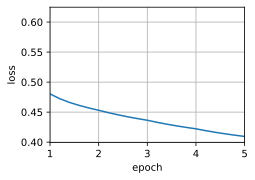

In [27]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

### 使用词嵌入
查找相近词

In [29]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32') 
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('chip', 10, net[0])

cosine sim=0.777: intel
cosine sim=0.703: microprocessor
cosine sim=0.631: laptop
cosine sim=0.620: dynamic
cosine sim=0.614: mainframes
cosine sim=0.593: memory
cosine sim=0.588: computers
cosine sim=0.586: chips
cosine sim=0.586: mainframe
cosine sim=0.565: optical


## 5. Word Embedding with Global Vectors ( [GloVe](!https://d2l.ai/chapter_natural-language-processing-pretraining/glove.html#skip-gram-with-global-corpus-statistics))
该模型利用大语料库中同时出现的词对计算每个词的词向量  


词词共现可能包含丰富的语义信息。  
例如，在一个大型语料库中，“solid”这个词更可能与“ice”共现，而不是“steam”，而“gas”这个词可能比“ice”更频繁地与“steam”共现。此外，可以预先计算此类共现的全语料库统计信息：这可以提高训练效率。  


- skip-gram 模型可以通过使用全局语料库统计信息，如词-词共现计数来解释。  
- 交叉熵损失可能不是衡量两个概率分布差异的好选择，尤其是对于大型语料库。GloVe 使用**平方损失**来拟合预先计算的全球语料库统计信息。  
- 中心词向量与上下文词向量在 GloVe 中对任何单词都是数学等价的。  
- GloVe 可以从词-词共现概率的比率中解释。

GloVe 损失函数如下  
$  \sum_{i\in\mathcal{V}} \sum_{j\in\mathcal{V}} h(x_{ij}) \left(\mathbf{u}_j^\top \mathbf{v}_i + b_i + c_j - \log\,x_{ij}\right)^2. $

## 6. 子词嵌入  
将词拆分为更小的词元部分，可以有效表示不同词态及长词、罕见词。  

### 6.1 fastText  
中心词由相关的不同词元相加表示  $ \mathbf{v}_w = \sum_{g\in\mathcal{G}_w} \mathbf{z}_g. $ 

### 6.2 Byte Pair Encoding BPE  
在 fastText 中，所有提取的子词都必须是指定的长度，例如 3 到 6 ，因此词汇表大小不能预先定义。  
为了在固定大小的词汇表中允许可变长度的子词，我们可以应用一种称为字节对编码（BPE）的压缩算法来提取子词（Sennrich 等人，2015 年）。  

字节对编码对训练数据集进行统计分析，以发现单词中的常见符号，例如任意长度的连续字符。  
从长度为 1 的符号开始，字节对编码迭代地将最频繁出现的连续符号对合并，以产生新的更长符号。请注意，为了效率，跨越单词边界的符号对不被考虑。最终，我们可以使用这些符号作为子词来分割单词。  

首先，我们将符号词汇初始化为所有英文字母小写、一个特殊的单词结束符号 '_' 和一个特殊的未知符号 '[UNK]' 。

In [50]:
symbols = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
           '_', '[UNK]']

由于我们不考虑跨越单词边界的符号对，我们只需要一个将单词映射到其频率（在数据集中的出现次数）的字典 raw_token_freqs 。请注意，特殊符号 '_' 被附加到每个单词上，这样我们就可以轻松地从输出符号序列（例如，“a_ tall er_ man”）中恢复单词序列（例如，“a taller man”）。由于我们从仅包含单个字符和特殊符号的词汇表开始合并过程，因此在每个单词（字典 token_freqs 的键）中相邻字符之间插入空格。换句话说，空格是单词内符号之间的分隔符。

In [51]:
raw_token_freqs = {'fast_': 4, 'faster_': 3, 'tall_': 5, 'taller_': 4}
token_freqs = {}
for token, freq in raw_token_freqs.items():
    token_freqs[' '.join(list(token))] = raw_token_freqs[token]
token_freqs

{'f a s t _': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}

该函数返回当前阶段的最频繁词对，后续将该词对添加到词元中

In [45]:
def get_max_freq_pair(token_freqs):
    pairs = collections.defaultdict(int)
    for token, freq in token_freqs.items():
        symbols = token.split()
        for i in range(len(symbols) - 1):
            # Key of `pairs` is a tuple of two consecutive symbols
            pairs[symbols[i], symbols[i + 1]] += freq
    return max(pairs, key=pairs.get)  # Key of `pairs` with the max value

In [40]:
#  将最频繁词对添加进词元表中，并将现有词对合并成一对词
def merge_symbols(max_freq_pair, token_freqs, symbols):
    symbols.append(''.join(max_freq_pair))
    new_token_freqs = dict()
    for token, freq in token_freqs.items():
        new_token = token.replace(' '.join(max_freq_pair),
                                  ''.join(max_freq_pair))
        new_token_freqs[new_token] = token_freqs[token]
    return new_token_freqs

测试

In [ ]:
num_merges = 10  # 合并 10 次
for i in range(num_merges):
    max_freq_pair = get_max_freq_pair(token_freqs)
    token_freqs = merge_symbols(max_freq_pair, token_freqs, symbols)
    print(f'merge #{i + 1}:', max_freq_pair)
    print(token_freqs)

In [ ]:
print(symbols)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]', 'ta', 'tal', 'tall', 'fa', 'fas', 'fast', 'er', 'er_', 'tall_', 'fast_']


使用得到的词元分解词库中单词， 得到每个单词的词元表示  
字节对编码的结果取决于所使用的数据集。我们还可以使用从一个数据集中学习到的子词来分割另一个数据集的单词。  
作为一个贪婪的方法，以下 segment_BPE 函数试图将输入参数 symbols 中的单词分割成**尽可能长**的子词。

In [48]:
def segment_BPE(tokens, symbols):
    outputs = []
    for token in tokens:
        start, end = 0, len(token)
        cur_output = []
        # Segment token with the longest possible subwords from symbols
        while start < len(token) and start < end:
            if token[start: end] in symbols:
                cur_output.append(token[start: end])
                start = end
                end = len(token)
            else:
                end -= 1
        if start < len(token):
            cur_output.append('[UNK]')
        outputs.append(' '.join(cur_output))
    return outputs

In [49]:
tokens = ['tallest_', 'fatter_']
print(segment_BPE(tokens, symbols))

['tall e s t _', 'fa t t er_']


## 7. 预训练向量  
[Glove](!https://nlp.stanford.edu/projects/glove/)  
[Fasttext](!https://fasttext.cc/docs/en/crawl-vectors.html)    
- 预训练词向量可以应用于词语相似性和类比任务。

In [53]:
#@save
d2l.DATA_HUB['glove.6b.50d'] = (d2l.DATA_URL + 'glove.6B.50d.zip', '0b8703943ccdb6eb788e6f091b8946e82231bc4d')

#@save
d2l.DATA_HUB['glove.6b.100d'] = (d2l.DATA_URL + 'glove.6B.100d.zip',
                                 'cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a')

#@save
d2l.DATA_HUB['glove.42b.300d'] = (d2l.DATA_URL + 'glove.42B.300d.zip',
                                  'b5116e234e9eb9076672cfeabf5469f3eec904fa')

#@save
d2l.DATA_HUB['wiki.en'] = (d2l.DATA_URL + 'wiki.en.zip',
                           'c1816da3821ae9f43899be655002f6c723e91b88')

创建词库

In [63]:
class TokenEmbedding:
    """Token Embedding."""
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = d2l.download_extract(embedding_name)
        # GloVe website: https://nlp.stanford.edu/projects/glove/
        # fastText website: https://fasttext.cc/
        with open(os.path.join(data_dir, 'vec.txt'), 'r', encoding='utf-8') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # Skip header information, such as the top row in fastText
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

加载 50 维的 GloVe 嵌入（在维基百科子集上预训练）

In [64]:
glove_6b50d = TokenEmbedding('glove.6b.50d')

词汇包含 400000 个单词（标记）和一个特殊的未知标记

In [65]:
len(glove_6b50d)

400001

### 单词相似性

In [82]:
def knn(W, x, k):
    # Add 1e-9 for numerical stability
    cos = torch.mv(W, x.reshape(-1,)) / (
        torch.sqrt(torch.sum(W * W, axis=1) + 1e-9) *
        torch.sqrt((x * x).sum()))
    vals, topk = torch.topk(cos, k=k)
    return topk, vals

#  搜索相似词
def get_similar_tokens(query_token, k, embed):
    topk, cos = knn(embed.idx_to_vec, embed[[query_token]], k + 1)
    for i, c in zip(topk[1:], cos[1:]):  # Exclude the input word
        print(f'cosine sim={float(c):.3f}: {embed.idx_to_token[int(i)]}')

In [83]:
get_similar_tokens('chip', 3, glove_6b50d)

cosine sim=0.856: chips
cosine sim=0.749: intel
cosine sim=0.749: electronics


### 单词类比  
我们还可以将词向量应用于词类比任务。例如，“man”（男人）:“woman”（女人）::“son”（儿子）:“daughter”（女儿）是词类比的一种形式：“man”（男人）对“woman”（女人）正如“son”（儿子）对“daughter”（女儿）。  
对于一个词类比 a:b::c:d ，给定前三个词 a 、 b 和 c ，找到 d 。将词 w 的向量表示为 vec(w) 。为了完成类比，我们将找到与 **vec(c)+vec(b)−vec(a)** 结果最相似的词的向量。

In [ ]:
def get_analogy(token_a, token_b, token_c, embed):
    vecs = embed[[token_a, token_b, token_c]]
    x = vecs[1] - vecs[0] + vecs[2]
    topk, cos = knn(embed.idx_to_vec, x, 1)
    return embed.idx_to_token[int(topk[0])]  # Remove unknown words

In [74]:
get_analogy('man', 'woman', 'son', glove_6b50d)

'daughter'

In [81]:
#  获取时态信息
get_analogy('do', 'did', 'go', glove_6b50d)

'went'

并不是所有语义都能捕捉

## 8. BERT (Bidirectional Encoder Representations from Transformers)  
使用上下文来学习词语的不同表示，例如某个单词有多种意思，需要根据具体上下文确定  
流行的上下文敏感表示包括 TagLM（语言模型增强序列标注器）（Peters 等人，2017 年），CoVe（上下文向量）（McCann 等人，2017 年）和 ELMo（语言模型嵌入）  
ELMo 双向编码上下文但使用特定任务的架构，其结构需要根据具体任务进行调整，实现较为复杂  
使用 GPT 实现任务无关的上下文敏感文字编码器， 但 GPT 自回归只会前向看，当模型需要根据后面的内容来给予输出时， GPT 无法实现。  
ELMo 双向编码上下文但使用特定任务的架构；而 GPT 对任务无特定要求但左右编码上下文。结合两者的优点，BERT（来自 Transformer 的双向编码表示）双向编码上下文，并且对广泛的自然语言处理任务仅需最小的架构调整（Devlin 等人，2018 年）。  

使用预训练的 Transformer 编码器，BERT 能够根据双向上下文表示任何标记。  
BERT 表示将被输入到一个额外的输出层，模型架构的调整取决于任务的性质，如预测每个标记与预测整个序列。  
其次，预训练的 Transformer 编码器的所有参数都进行了微调，而**额外的输出层**将从头开始训练。图 15.8.1 描述了 ELMo、GPT 和 BERT 之间的差异。  

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411060923828.png" width='600px' >
</div>  

BERT 用来提出输入文本的语义特征，不同于 word2vec 的词嵌入

- BERT针对微调设计
- 基于 Transformer 的编码器做了如下修改
  1. 模型更大，训练数据更多
  2. 输入句子对，片段嵌入，可学习的位置编码
  3. 训练时使用两个任务：带掩码的语言模型； 下一个句子预测

### BERT 输入表示 （BERT Encoder）
在自然语言处理中，某些任务（例如情感分析）以单个文本作为输入，而在某些其他任务（例如自然语言推理）中，输入是一对文本序列。BERT 输入序列明确地表示单个文本和文本对。  
单文本输入时， 使用 < cls > + 文本序列 token + < sep >,  文本对输入时， 使用 < cls > + 文本序列 token + < sep > + 文本序列 token + < sep >  
为了在文本对中区分不同文本， 使用段嵌入(segment embedding)进行编码，单文本输入仅使用单个编码   

In [3]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """Get tokens of the BERT input sequence and their segment IDs."""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 使用0， 1 分别编码不同的 segment
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411060934589.png" width='600px' >
</div>  

BERTEncodr 使用可学习的**位置嵌入**

In [4]:
class BERTEncoder(nn.Module):
    """BERT encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout, max_len=1000, **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", d2l.TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, True))
        # In BERT, positional embeddings are learnable, thus we create a
        # parameter of positional embeddings that are long enough
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # Shape of `X` remains unchanged in the following code snippet:
        # (batch size, max sequence length, `num_hiddens`)
        X = self.token_embedding(tokens) + self.segment_embedding(segments)  # 根据segments索引选择对应的 segment code 添加进 token 的编码
        X = X + self.pos_embedding[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

测试

In [5]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
ffn_num_input, num_blks, dropout = 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                      num_blks, dropout)  

#  测试
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

d:\Anaconda3\envs\data_torch\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([2, 8, 768])

### Masked Language Modeling  
自监督任务，随机预测原始文本中某个 token  
为了双向编码上下文以表示每个标记，BERT 随机掩码标记，并使用双向上下文中的标记以自监督方式预测掩码标记。这项任务被称为掩码语言模型。  
在此预训练任务中，将随机选择 15%的标记作为预测的掩码标记。为了预测一个掩码标记而不通过使用标签作弊，一个简单的方法是在 BERT 输入序列中始终将其替换为特殊的 < mask >  
然而，人工特殊标记“< mask >”在微调时永远不会出现。为了避免预训练和微调之间的这种不匹配，如果一个标记被遮蔽用于预测（例如，在“this movie is great”中选择“great”进行遮蔽和预测），则在输入中它将被替换为： 
- a special “<mask>” token for 80% of the time (e.g., “this movie is great” becomes “this movie is <mask>”); 
- a random token for 10% of the time (e.g., “this movie is great” becomes “this movie is drink”); 
- the unchanged label token for 10% of the time (e.g., “this movie is great” becomes “this movie is great”).  
在 15%的时间中有 10%的时间会插入一个随机标记。这种偶尔的噪声鼓励 BERT 在双向上下文编码中对其掩码标记的偏见减少（尤其是当标签标记保持不变时）。

In [6]:
# 在正向推理中，它接受两个输入： BERTEncoder 的编码结果和预测的标记位置。输出是这些位置的预测结果。
class MaskLM(nn.Module):
    """The masked language model task of BERT."""
    def __init__(self, vocab_size, num_hiddens, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.LazyLinear(num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.LazyLinear(vocab_size))

    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # Suppose that `batch_size` = 2, `num_pred_positions` = 3, then
        # `batch_idx` is `torch.tensor([0, 0, 0, 1, 1, 1])`
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]  # 从 X 中选出需要预测的推理向量
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)  # 计算 masked token 对应的预测 token
        return mlm_Y_hat

测试

In [7]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

使用 cross_entropy 计算预测分类损失

In [8]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

torch.Size([6])

### 下一个句子输入

尽管掩码语言模型能够编码双向上下文来表示词语，但它并未显式地建模文本对之间的逻辑关系。  
为了帮助理解两个文本序列之间的关系，BERT 在其预训练中考虑了一个二元分类任务，即下一句预测。  
在生成用于预训练的句子对时，其中一半时间确实是连续的句子，带有标签“True”；而另一半时间，第二个句子则是从语料库中随机抽取的（人工随机生成对应的非配对句子），带有标签“False”。

该模型的输入 X 为 BERTEncoder 在 < cls > 位置上对应的输出

In [9]:
class NextSentencePred(nn.Module):
    """The next sentence prediction task of BERT."""
    def __init__(self, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.LazyLinear(2)

    def forward(self, X):
        # `X` shape: (batch size, `num_hiddens`)
        return self.output(X)

In [10]:
# PyTorch by default will not flatten the tensor as seen in mxnet where, if
# flatten=True, all but the first axis of input data are collapsed together
encoded_X = torch.flatten(encoded_X, start_dim=1)
# input_shape for NSP: (batch size, `num_hiddens`)
nsp = NextSentencePred()
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 2])

In [11]:
torch.flatten(encoded_X, start_dim=1).shape

torch.Size([2, 6144])

交叉熵损失也可以计算两个二进制分类

In [12]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

### 最终推理模型 
预训练 BERT 包括两个任务：掩码语言建模和下一句预测。前者能够编码双向上下文以表示词语，而后者明确地建模文本对之间的逻辑关系。  
在预训练 BERT 时，最终的损失函数是掩码语言模型损失函数和下一句预测损失函数的线性组合。

In [13]:
#  该模型前向推理返回编码后的 BERT 表示 encoded_X 、掩码语言模型的预测 mlm_Y_hat 和下一句预测 nsp_Y_hat
class BERTModel(nn.Module):
    """The BERT model."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, max_len=1000):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens,
                                   num_heads, num_blks, dropout,
                                   max_len=max_len)
        self.hidden = nn.Sequential(nn.LazyLinear(num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens)
        self.nsp = NextSentencePred()

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # The hidden layer of the MLP classifier for next sentence prediction.
        # 0 is the index of the '<cls>' token
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

## 9. 预训练 BERT 的数据集   
在定制数据集上预训练 BERT 变得越来越流行  
- 使用 BERT 预训练模型，需要同时获得该模型对应的 vocab， 用于将文本的token 映射到 预训练BERT 中相应的 index

WikiText-2保留了原始标点，使其适合用于下一句预测；保留了原始的大小写和数字  
在 WikiText-2 数据集中，每一行代表一个段落，其中标点符号与其前面的标记之间插入空格。保留至少包含两个句子的段落。为了简化，我们仅使用句号作为分隔符来分割句子。

In [40]:
def _read_wiki():
    file_name = os.path.join('E:\doing\DL\divedeep\data\wikitext_2_v1', 'train-00000-of-00001.parquet')
    file = pd.read_parquet(file_name)
    # Uppercase letters are converted to lowercase ones
    paragraphs = [line.strip().lower().split(' . ')
                  for line in file['text'] if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

### 生成用于是否 下一个句子 任务的训练集

In [26]:
#  是否为下一个句子， 否的话从段落集中随机选择一个句子 (是否会选择到相同的)
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        # `paragraphs` is a list of lists of lists
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

In [27]:
#  根据 max_len 限制， 生成相应的数据集
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        # Consider 1 '<cls>' token and 2 '<sep>' tokens
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph

### 生成 掩码模型 数据集  
tokens 是一个表示 BERT 输入序列的标记列表， candidate_pred_positions 是 BERT 输入序列的标记索引列表，  
排除了特殊标记的索引（在掩码语言建模任务中不预测特殊标记）， num_mlm_preds 表示预测的数量（回忆 15%的随机标记进行预测）

In [28]:
#  生成单个句子的训练样本
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds,
                        vocab):
    # For the input of a masked language model, make a new copy of tokens and
    # replace some of them by '<mask>' or random tokens
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    # Shuffle for getting 15% random tokens for prediction in the masked
    # language modeling task
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        # 80% of the time: replace the word with the '<mask>' token
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10% of the time: keep the word unchanged
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10% of the time: replace the word with a random word
            else:
                masked_token = random.choice(vocab.idx_to_token)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels

In [29]:
#  仅当字典中有存在从 0 - n的 key时， 使用 random.choice 可以进行随机选择出对应的 value 
test = {0:'c', 1:'a', 2:'b'}
random.choice(test)

'c'

In [30]:
def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    # `tokens` is a list of strings
    for i, token in enumerate(tokens):
        # Special tokens are not predicted in the masked language modeling
        # task
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    # 15% of random tokens are predicted in the masked language modeling task
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                       key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]  # 将 token 转换为对应的 index

### 将文本数据转换为训练数据  
通过对 掩码预测 及 下一个句子 得到的数据处理，填充 < pad > 符号，对每一个样本处理成相应需要的部分  
examples 包含来自两个预训练任务的辅助函数 _get_nsp_data_from_paragraph 和 _get_mlm_data_from_tokens 的输出

In [52]:
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens,  = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments,
         is_next) in examples:
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0] * (
            max_len - len(segments)), dtype=torch.long))
        # `valid_lens` excludes count of '<pad>' tokens
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        # Predictions of padded tokens will be filtered out in the loss via
        # multiplication of 0 weights
        # len (pred_positions)  == len (mlm_pred_label_ids)
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(mlm_pred_label_ids)),
                dtype=torch.float32))
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (
            max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)

_WikiTextDataset 类作为预训练 BERT 的 WikiText-2 数据集。通过实现 __getitem__ 函数，我们可以任意访问从 WikiText-2 语料库中的一对句子生成的预训练（掩码语言建模和下一句预测）示例    
原始 BERT 模型使用词汇量为 30000 的 WordPiece 嵌入（Wu 等人，2016 年）。WordPiece 的标记化方法是 15.6.2 节中 BPE 算法的微小修改。  
为了简化，我们使用 d2l.tokenize 函数进行标记化。出现次数少于五次的罕见标记将被过滤掉。

- 先从文本中获得上下文训练的样本及 is_next label
- 对上步获得样本进行处理，创建预测 masked_token 的训练数据  

In [53]:
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        # Input `paragraphs[i]` is a list of sentence strings representing a
        # paragraph; while output `paragraphs[i]` is a list of sentences
        # representing a paragraph, where each sentence is a list of tokens
        paragraphs = [d2l.tokenize(
            paragraph, token='word') for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs
                     for sentence in paragraph]  # sentences 是从 paragraphs 中收集的所有句子， 每个句子中包含所有 token
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=[
            '<pad>', '<mask>', '<cls>', '<sep>'])
        # Get data for the next sentence prediction task
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len))
        # Get data for the masked language model task
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                      + (segments, is_next))
                     for tokens, segments, is_next in examples]
        # Pad inputs
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
            examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])

    def __len__(self):
        return len(self.all_token_ids)

### 创建训练数据集

In [50]:
def load_data_wiki(batch_size, max_len):
    """Load the WikiText-2 dataset."""
    # data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    paragraphs = _read_wiki()
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
    return train_iter, train_set.vocab

In [54]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)  # 加载训练数据集 

for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
          nsp_y.shape)
    break

#  10 = 64 * 0.15 表示 mask 模型需要预测的token

torch.Size([512, 64]) torch.Size([512, 64]) torch.Size([512]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512])


In [43]:
len(vocab)

20256

其他分句分词的方法    spaCy 和 NLTK   
为简化起见，期间用作分割句子的唯一分隔符。尝试其他句子分割技术，如 spaCy 和 NLTK。以 NLTK 为例。首先需要安装 NLTK： pip install nltk 。在代码中，首先 import nltk 。然后，下载 Punkt 句子分词器： nltk.download('punkt') 。要分割如 sentences = 'This is great ! Why not ?' 的句子，调用 nltk.tokenize.sent_tokenize(sentences) 将返回两个句子字符串的列表： ['This is great !', 'Why not ?'] 。

## 10. BERT 预训练  
原始 BERT 有两个不同模型大小的版本（Devlin 等人，2018）。基础模型使用 12 层（Transformer 编码器块）和 768 个隐藏单元（隐藏大小）以及 12 个自注意力头。  
大型模型使用 24 层，1024 个隐藏单元和 16 个自注意力头。值得注意的是，前者有 1.1 亿个参数，而后者有 3.4 亿个参数。  
为了便于演示，我们定义了一个小 BERT，使用 2 层，128 个隐藏单元和 2 个自注意力头。  
保证每个头的隐藏空间维度为 64。

In [ ]:
net = BERTModel(len(vocab), num_hiddens=128,
                    ffn_num_hiddens=256, num_heads=2, num_blks=2, dropout=0.2)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

d:\Anaconda3\envs\data_torch\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


BERT 训练损失为 masked 损失及 next sentence 损失的和

In [57]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # Compute masked language model loss
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) * mlm_weights_X.reshape(-1, 1)  # 拉平预测结果为单个维度
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

### 训练

In [58]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net(*next(iter(train_iter))[:4])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])  # 分布式训练
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # Sum of masked language modeling losses, sum of next sentence prediction
    # losses, no. of sentence pairs, count
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

MLM loss 5.341, NSP loss 0.769
3246.0 sentence pairs/sec on [device(type='cuda', index=0)]


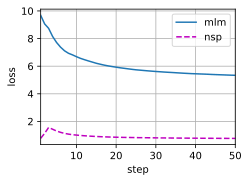

In [59]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

### 测试

使用训练得到的 Encoder 获得序列单词中的的 embedding，  
由于添加了 position 及 segment 信息， 不同于 word2vec ， Encoder的编码可以准确获得上下文信息。

In [61]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = get_tokens_and_segments(tokens_a, tokens_b)  # 获得对应的合并 tokens 及 segment
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)  # 获得 tokens 对应的 encoded 编码值
    return encoded_X

考虑句子“一只起重机正在飞翔”。  
回忆第 15.8.4 节中讨论的 BERT 输入表示。在插入特殊标记（用于分类）和（用于分隔）后，BERT 输入序列长度为六。  
由于零是< cls>标记的索引， encoded_text[:, 0, :] 是整个输入句子的 BERT 表示。  
为了评估多义词“起重机”，打印出标记的 BERT 表示的前三个元素。

In [62]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([-0.1984,  1.8864,  0.0079], device='cuda:0', grad_fn=<SliceBackward0>))

In [65]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# Tokens: '<cls>', 'a', 'crane', 'driver', 'came', '<sep>', 'he', 'just',
# 'left', '<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]  # crane 单词的编码输出与之前不同，表示 BERT 支持提取上下文信息

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([ 1.5137,  0.1096, -0.3775], device='cuda:0', grad_fn=<SliceBackward0>))

- BERT 原始版本有两种，其中基础模型有 1.1 亿个参数，大型模型有 3.4 亿个参数。  
- 在预训练 BERT 之后，我们可以用它来表示单个文本、文本对或其中的任何标记。  
- 在实验中，相同的标记在不同的上下文中具有不同的 BERT 表示。这支持 BERT 表示是上下文敏感的。